# **social behavior simulation model**

In [ ]:
!pip install mesa matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.7/425.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 1

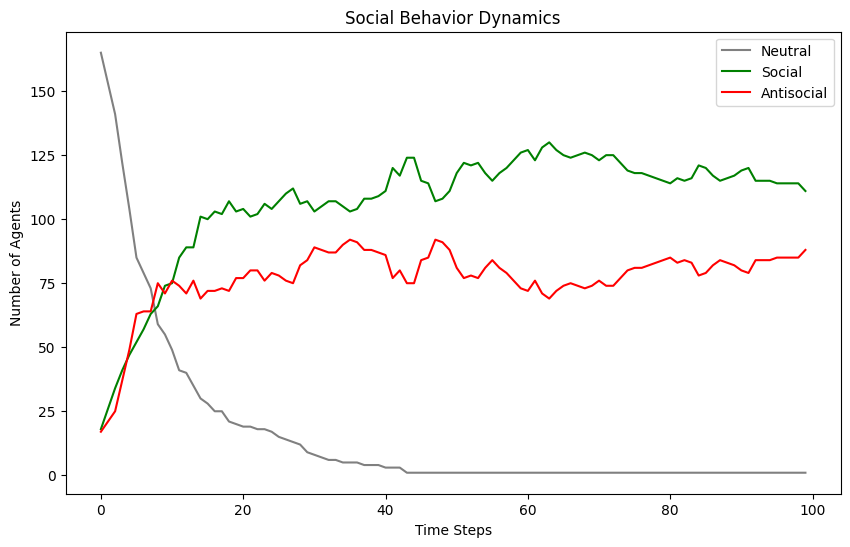

In [ ]:
import random
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt

# Constants to represent social states
NEUTRAL = 0 #not exhibit any particular social behavior.
SOCIAL = 1 #engages positively with others
ANTISOCIAL = 2 #engages negatively with others

class SocialAgent(Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = NEUTRAL  # Start with a neutral social state

    def step(self):
        self.interact()  # Agents interact with neighbors

    def interact(self):
        """Interact with neighboring agents to influence social behavior."""
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        for neighbor in neighbors:
            # Influence behavior based on neighbor's state
            if neighbor.state == SOCIAL:
                if random.random() < self.model.influence_prob:
                    self.state = SOCIAL
            elif neighbor.state == ANTISOCIAL:
                if random.random() < self.model.influence_prob:
                    self.state = ANTISOCIAL

class SocialModel(Model):
    """A model with some number of agents exhibiting social behavior."""

    def __init__(self, N, width, height, influence_prob):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.influence_prob = influence_prob  # Probability of influence during interaction

        # Create agents
        for i in range(self.num_agents):
            a = SocialAgent(i, self)
            self.grid.place_agent(a, (self.random.randrange(self.grid.width),
                                       self.random.randrange(self.grid.height)))
            self.schedule.add(a)

        # Randomly set some agents to start as SOCIAL or ANTISOCIAL
        for _ in range(int(0.1 * N)):  # 10% start as SOCIAL
            agent = random.choice(self.schedule.agents)
            agent.state = SOCIAL

        for _ in range(int(0.1 * N)):  # 10% start as ANTISOCIAL
            agent = random.choice(self.schedule.agents)
            agent.state = ANTISOCIAL

        # Initialize data collector to track the number of agents in each state at each time step.

        self.datacollector = DataCollector(
            {"Neutral": lambda m: self.count_state(m, NEUTRAL),
             "Social": lambda m: self.count_state(m, SOCIAL),
             "Antisocial": lambda m: self.count_state(m, ANTISOCIAL)}
        )

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()

    @staticmethod
    def count_state(model, state):
        """Count how many agents have a given state."""
        count = 0
        for agent in model.schedule.agents:
            if agent.state == state:
                count += 1
        return count

if __name__ == '__main__':
    model = SocialModel(200, width=20, height=20, influence_prob=0.1)

    steps = 100
    for i in range(steps):
        model.step()

    # Collect data
    data = model.datacollector.get_model_vars_dataframe()

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(data['Neutral'], label='Neutral', color='gray')
    plt.plot(data['Social'], label='Social', color='green')
    plt.plot(data['Antisocial'], label='Antisocial', color='red')
    plt.title("Social Behavior Dynamics")
    plt.xlabel("Time Steps")
    plt.ylabel("Number of Agents")
    plt.legend()
    plt.show()
